In [1]:
import numpy as np
import logging
import matplotlib.pyplot as plt

from scrs.constants import OUT_DIR
from scrs import Image

In [2]:
IMG_SIZE = (9000, 9000)

logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)

logger = logging.getLogger()

In [4]:
# Loading sim data
img = Image().load_fits(OUT_DIR / 'curr' / 'data.fits')
cosmics = img.get_diff(1, 2).data
true_mask = (cosmics > 0)

# Loading lacosmic mask
lc_cr_mask = Image().load_fits(OUT_DIR / 'curr' / 'lacosmic_cr.fits').data

# Loading pyplot mask
pc_cr_mask = Image().load_fits(OUT_DIR / 'curr' / 'pycosmic_cr.fits').data

# Loading astroscrappy mask
as_cr_mask = Image().load_fits(OUT_DIR / 'curr' / 'astroscrappy_cr.fits').data

INFO:scrs.image.image:Ran load_fits on image.
INFO:scrs.image.image:Ran set_data on image.
INFO:scrs.image.image:Ran set_data on image.
INFO:scrs.image.image:Ran set_data on image.
INFO:scrs.image.image:Ran load_fits on image.
INFO:scrs.image.image:Ran load_fits on image.
INFO:scrs.image.image:Ran load_fits on image.


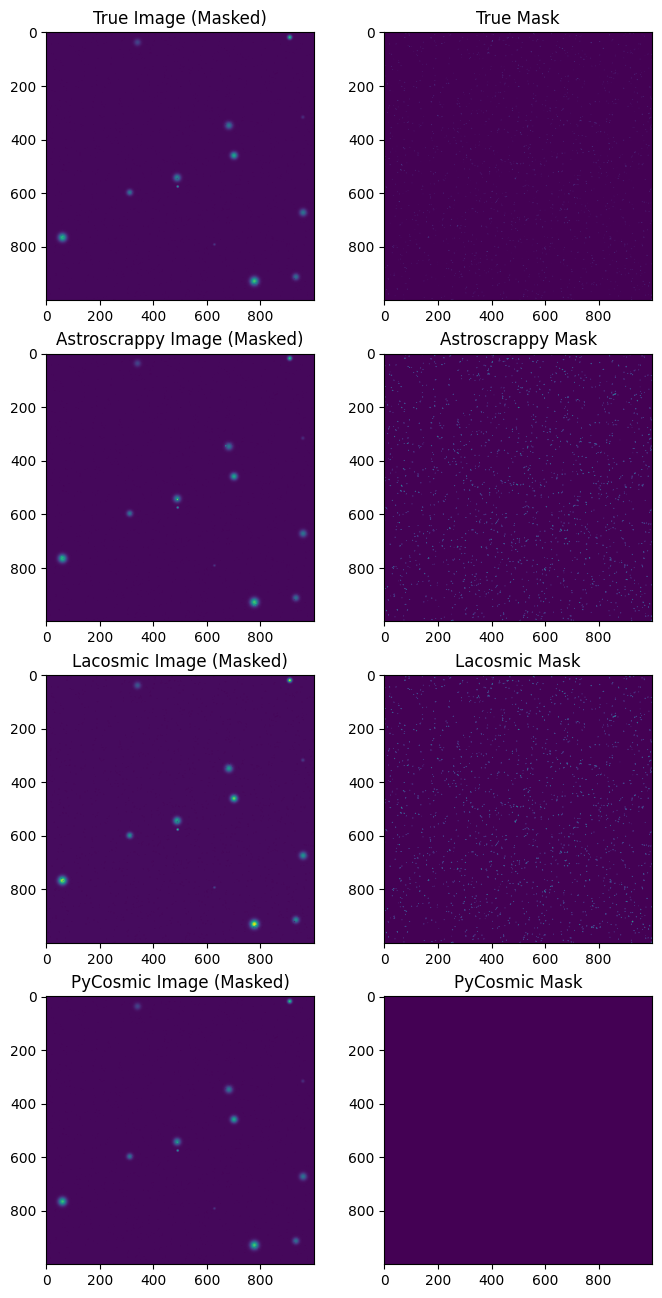

In [5]:
# Show cosmic ray image, true image, and 3 versions of the masked image
region = slice(0, 1000), slice(0, 1000)

VMAX = np.ma.masked_array(img.data, mask=true_mask).max()

ROWS = 4
COLS = 2
MULT = 4

fig, ax = plt.subplots(ROWS, COLS, figsize=(COLS * MULT, ROWS * MULT))

i = 0

ax[i, 0].set_title("True Image (Masked)")
ax[i, 0].imshow(np.ma.masked_array(img.data, mask=true_mask).filled(0)[region], vmin=0, vmax=VMAX)

ax[i, 1].set_title("True Mask")
ax[i, 1].imshow(cosmics[region])

i += 1
ax[i, 0].set_title("Astroscrappy Image (Masked)")
ax[i, 0].imshow(np.ma.masked_array(img.data, mask=as_cr_mask).filled(0)[region], vmin=0, vmax=VMAX)

ax[i, 1].set_title("Astroscrappy Mask")
ax[i, 1].imshow(as_cr_mask[region])

i += 1
ax[i, 0].set_title("Lacosmic Image (Masked)")
ax[i, 0].imshow(np.ma.masked_array(img.data, mask=lc_cr_mask).filled(0)[region])

ax[i, 1].set_title("Lacosmic Mask")
ax[i, 1].imshow(lc_cr_mask[region])

i += 1
ax[i, 0].set_title("PyCosmic Image (Masked)")
ax[i, 0].imshow(np.ma.masked_array(img.data, mask=pc_cr_mask).filled(0)[region], vmin=0, vmax=VMAX)

ax[i, 1].set_title("PyCosmic Mask")
ax[i, 1].imshow(pc_cr_mask[region], vmin=0, vmax=VMAX)

plt.show()


In [ ]:
norm = img.data / img.data.max()
stacked = np.dstack([norm] * 3)

# Astroscrappy
as_mask_img = np.dstack([as_cr_mask, true_mask, np.zeros_like(img.data)])

correct = as_cr_mask & true_mask
as_mask_img[correct] = [0, 0, 1]

detected = as_cr_mask | true_mask
as_mask_img[~detected] = stacked[~detected]

# LAcosmic
lc_mask_img = np.dstack([lc_cr_mask, true_mask, np.zeros_like(img.data)])

correct = lc_cr_mask & true_mask
lc_mask_img[correct] = [0, 0, 1]

detected = lc_cr_mask | true_mask
lc_mask_img[~detected] = stacked[~detected]

# PyCosmic
py_mask_img = np.dstack([pc_cr_mask, true_mask, np.zeros_like(img.data)])
correct = pc_cr_mask & true_mask
py_mask_img[correct] = [0, 0, 1]
detected = pc_cr_mask | true_mask
py_mask_img[~detected] = stacked[~detected]

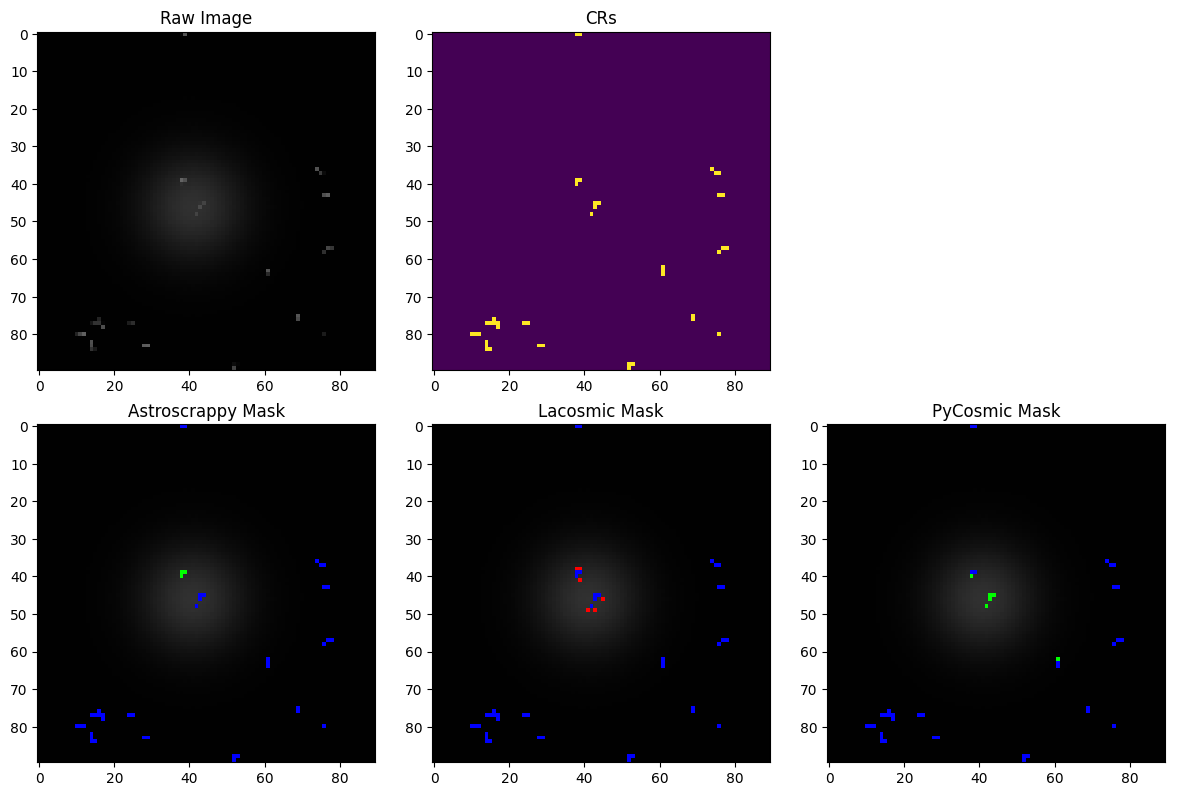

In [ ]:
region = slice(720, 810), slice(20, 110)
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

# Red = false-negative
# Green = false-positive
# Blue = true-positive

ax[0][0].set_title("Raw Image")
ax[0][0].imshow(stacked[region], cmap="gray")

# Get cosmics as 1s only
cosmic_mask = cosmics.copy()
cosmic_mask[cosmics > 0] = 1

ax[0][1].set_title("CRs")
ax[0][1].imshow(cosmic_mask[region])

ax[0][2].axis("off")

ax[1][0].set_title("Astroscrappy Mask")
ax[1][0].imshow(as_mask_img[region])

ax[1][1].set_title("Lacosmic Mask")
ax[1][1].imshow(lc_mask_img[region])

ax[1][2].set_title("PyCosmic Mask")
ax[1][2].imshow(py_mask_img[region])

plt.tight_layout()
plt.show()